Story so far:

Hasta el aproximador lineal todo fue bastante agradable.

A la hora de implementar la red neuronal me topé con:
* los estados (mapa+score) están en ascii < a la NN no le gusta ésto
* Después de mil quilombos de tipos, la NN conecta con el agente
* PERO parece no aprender nada
  * Posibles causas: 
    * a. updateo mal los weights (sospecho que es en la derivada parcial con respecto a $\hat{q}(S,A)$)
    * b. tarda mucho en aprender algo que sirva (al principio)
    * c. la estructura de la NN es una chota
  * Solución
    1. Grabar un par de juegos con el aprox lineal
    2. Usar Sup.Learning para aproximar una función a los juegos guardados (no online learning)
    3. Si puedo overfitear con la misma NN, entonces puede aprender online, sino no
    4. Si se cumple 3., puedo:
       * descartar c.
       * inicializar weights con lo aprendido, y también descartar b.
    
En el medio me encontré con que:
* no se guardaban bien los juegos porque usaron codigo de python 2 con pickle y no lo updatearon.
* Dependencias circulares (imports mutuos) entre un par de archivos.


In [52]:
# Licensing Information: You are free to use or extend these projects for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to UC Berkeley, including a link to http://ai.berkeley.edu.
#
# Attribution Information: The Pacman AI projects were developed at UC Berkeley.
# The core projects and autograders were primarily created by John DeNero
# (denero@cs.berkeley.edu) and Dan Klein (klein@cs.berkeley.edu).
# Student side autograding was added by Brad Miller, Nick Hay, and
# Pieter Abbeel (pabbeel@cs.berkeley.edu).

In [53]:
## for testing
SOME_GLOBAL_STATE = ""

In [54]:
"""
Pacman.py holds the logic for the classic pacman game along with the main
code to run a game.  This file is divided into three sections:

  (i)  Your interface to the pacman world:
          Pacman is a complex environment.  You probably don't want to
          read through all of the code we wrote to make the game runs
          correctly.  This section contains the parts of the code
          that you will need to understand in order to complete the
          project.  There is also some code in game.py that you should
          understand.

  (ii)  The hidden secrets of pacman:
          This section contains all of the logic code that the pacman
          environment uses to decide who can move where, who dies when
          things collide, etc.  You shouldn't need to read this section
          of code, but you can if you want.

  (iii) Framework to start a game:
          The final section contains the code for reading the command
          you use to set up the game, then starting up a new game, along with
          linking in all the external parts (agent functions, graphics).
          Check this section out to see all the options available to you.
"""

import import_ipynb
import numpy as np
from game import GameStateData
from game import Game
from game import Directions
from game import Actions
from util import nearestPoint
from util import manhattanDistance
import util
import layout
import sys
import types
import time
import random
import os

###################################################
# YOUR INTERFACE TO THE PACMAN WORLD: A GameState #
###################################################


class GameState:
    """
    A GameState specifies the full game state, including the food, capsules,
    agent configurations and score changes.

    GameStates are used by the Game object to capture the actual state of the game and
    can be used by agents to reason about the game.

    Much of the information in a GameState is stored in a GameStateData object.  We
    strongly suggest that you access that data via the accessor methods below rather
    than referring to the GameStateData object directly.

    Note that in classic Pacman, Pacman is always agent 0.
    """

    ####################################################
    # Accessor methods: use these to access state data #
    ####################################################

    # static variable keeps track of which states have had getLegalActions called
    explored = set()

    def getAndResetExplored():
        tmp = GameState.explored.copy()
        GameState.explored = set()
        return tmp
    getAndResetExplored = staticmethod(getAndResetExplored)

    def getLegalActions(self, agentIndex=0):
        """
        Returns the legal actions for the agent specified.
        """
#        GameState.explored.add(self)
        if self.isWin() or self.isLose():
            return []

        if agentIndex == 0:  # Pacman is moving
            return PacmanRules.getLegalActions(self)
        else:
            return GhostRules.getLegalActions(self, agentIndex)

    def generateSuccessor(self, agentIndex, action):
        """
        Returns the successor state after the specified agent takes the action.
        """
        # Check that successors exist
        if self.isWin() or self.isLose():
            raise Exception('Can\'t generate a successor of a terminal state.')

        # Copy current state
        state = GameState(self)

        # Let agent's logic deal with its action's effects on the board
        if agentIndex == 0:  # Pacman is moving
            state.data._eaten = [False for i in range(state.getNumAgents())]
            PacmanRules.applyAction(state, action)
        else:                # A ghost is moving
            GhostRules.applyAction(state, action, agentIndex)

        # Time passes
        if agentIndex == 0:
            state.data.scoreChange += -TIME_PENALTY  # Penalty for waiting around
        else:
            GhostRules.decrementTimer(state.data.agentStates[agentIndex])

        # Resolve multi-agent effects
        GhostRules.checkDeath(state, agentIndex)

        # Book keeping
        state.data._agentMoved = agentIndex
        state.data.score += state.data.scoreChange
        GameState.explored.add(self)
        GameState.explored.add(state)
        return state

    def getLegalPacmanActions(self):
        return self.getLegalActions(0)

    def generatePacmanSuccessor(self, action):
        """
        Generates the successor state after the specified pacman move
        """
        return self.generateSuccessor(0, action)

    def getPacmanState(self):
        """
        Returns an AgentState object for pacman (in game.py)

        state.pos gives the current position
        state.direction gives the travel vector
        """
        return self.data.agentStates[0].copy()

    def getPacmanPosition(self):
        return self.data.agentStates[0].getPosition()

    def getGhostStates(self):
        return self.data.agentStates[1:]

    def getGhostState(self, agentIndex):
        if agentIndex == 0 or agentIndex >= self.getNumAgents():
            raise Exception("Invalid index passed to getGhostState")
        return self.data.agentStates[agentIndex]

    def getGhostPosition(self, agentIndex):
        if agentIndex == 0:
            raise Exception("Pacman's index passed to getGhostPosition")
        return self.data.agentStates[agentIndex].getPosition()

    def getGhostPositions(self):
        return [s.getPosition() for s in self.getGhostStates()]

    def getNumAgents(self):
        return len(self.data.agentStates)

    def getScore(self):
        return float(self.data.score)

    def getCapsules(self):
        """
        Returns a list of positions (x,y) of the remaining capsules.
        """
        return self.data.capsules

    def getNumFood(self):
        return self.data.food.count()

    def getFood(self):
        """
        Returns a Grid of boolean food indicator variables.

        Grids can be accessed via list notation, so to check
        if there is food at (x,y), just call

        currentFood = state.getFood()
        if currentFood[x][y] == True: ...
        """
        return self.data.food

    def getWalls(self):
        """
        Returns a Grid of boolean wall indicator variables.

        Grids can be accessed via list notation, so to check
        if there is a wall at (x,y), just call

        walls = state.getWalls()
        if walls[x][y] == True: ...
        """
        return self.data.layout.walls

    def hasFood(self, x, y):
        return self.data.food[x][y]

    def hasWall(self, x, y):
        return self.data.layout.walls[x][y]

    def isLose(self):
        return self.data._lose

    def isWin(self):
        return self.data._win

    #############################################
    #             Helper methods:               #
    # You shouldn't need to call these directly #
    #############################################

    def __init__(self, prevState=None):
        """
        Generates a new state by copying information from its predecessor.
        """
        if prevState != None:  # Initial state
            self.data = GameStateData(prevState.data)
        else:
            self.data = GameStateData()

    def deepCopy(self):
        state = GameState(self)
        state.data = self.data.deepCopy()
        return state

    def __eq__(self, other):
        """
        Allows two states to be compared.
        """
        return hasattr(other, 'data') and self.data == other.data

    def __hash__(self):
        """
        Allows states to be keys of dictionaries.
        """
        return hash(self.data)

    def __str__(self):

        return str(self.data)

    def initialize(self, layout, numGhostAgents=1000):
        """
        Creates an initial game state from a layout array (see layout.py).
        """
        self.data.initialize(layout, numGhostAgents)

############################################################################
#                     THE HIDDEN SECRETS OF PACMAN                         #
#                                                                          #
# You shouldn't need to look through the code in this section of the file. #
############################################################################


SCARED_TIME = 40    # Moves ghosts are scared
COLLISION_TOLERANCE = 0.7  # How close ghosts must be to Pacman to kill
TIME_PENALTY = 1  # Number of points lost each round


class ClassicGameRules:
    """
    These game rules manage the control flow of a game, deciding when
    and how the game starts and ends.
    """

    def __init__(self, timeout=30):
        self.timeout = timeout

    def newGame(self, layout, pacmanAgent, ghostAgents, display, quiet=False, catchExceptions=False):
        agents = [pacmanAgent] + ghostAgents[:layout.getNumGhosts()]
        initState = GameState()
        initState.initialize(layout, len(ghostAgents))
        game = Game(agents, display, self, catchExceptions=catchExceptions)
        game.state = initState
        self.initialState = initState.deepCopy()
        self.quiet = quiet
        return game

    def process(self, state, game):
        """
        Checks to see whether it is time to end the game.
        """
        
#         print("state2:", len(str(state)), np.asarray(str(state)).flatten()) #--------------------------------------------<
        global SOME_GLOBAL_STATE 
        SOME_GLOBAL_STATE = state
        
        if state.isWin():
            self.win(state, game)
        if state.isLose():
            self.lose(state, game)

    def win(self, state, game):
        if not self.quiet:
            print("Pacman emerges victorious! Score: %d" % state.data.score)
        game.gameOver = True

    def lose(self, state, game):
        if not self.quiet:
            print("Pacman died! Score: %d" % state.data.score)
        game.gameOver = True

    def getProgress(self, game):
        return float(game.state.getNumFood()) / self.initialState.getNumFood()

    def agentCrash(self, game, agentIndex):
        if agentIndex == 0:
            print("Pacman crashed")
        else:
            print("A ghost crashed")

    def getMaxTotalTime(self, agentIndex):
        return self.timeout

    def getMaxStartupTime(self, agentIndex):
        return self.timeout

    def getMoveWarningTime(self, agentIndex):
        return self.timeout

    def getMoveTimeout(self, agentIndex):
        return self.timeout

    def getMaxTimeWarnings(self, agentIndex):
        return 0


class PacmanRules:
    """
    These functions govern how pacman interacts with his environment under
    the classic game rules.
    """
    PACMAN_SPEED = 1

    def getLegalActions(state):
        """
        Returns a list of possible actions.
        """
        return Actions.getPossibleActions(state.getPacmanState().configuration, state.data.layout.walls)
    getLegalActions = staticmethod(getLegalActions)

    def applyAction(state, action):
        """
        Edits the state to reflect the results of the action.
        """
        legal = PacmanRules.getLegalActions(state)
        if action not in legal:
            raise Exception("Illegal action " + str(action))

        pacmanState = state.data.agentStates[0]

        # Update Configuration
        vector = Actions.directionToVector(action, PacmanRules.PACMAN_SPEED)
        pacmanState.configuration = pacmanState.configuration.generateSuccessor(
            vector)

        # Eat
        next = pacmanState.configuration.getPosition()
        nearest = nearestPoint(next)
        if manhattanDistance(nearest, next) <= 0.5:
            # Remove food
            PacmanRules.consume(nearest, state)
    applyAction = staticmethod(applyAction)

    def consume(position, state):
        x, y = position
        # Eat food
        if state.data.food[x][y]:
            state.data.scoreChange += 10
            state.data.food = state.data.food.copy()
            state.data.food[x][y] = False
            state.data._foodEaten = position
            # TODO: cache numFood?
            numFood = state.getNumFood()
            if numFood == 0 and not state.data._lose:
                state.data.scoreChange += 500
                state.data._win = True
        # Eat capsule
        if(position in state.getCapsules()):
            state.data.capsules.remove(position)
            state.data._capsuleEaten = position
            # Reset all ghosts' scared timers
            for index in range(1, len(state.data.agentStates)):
                state.data.agentStates[index].scaredTimer = SCARED_TIME
    consume = staticmethod(consume)


class GhostRules:
    """
    These functions dictate how ghosts interact with their environment.
    """
    GHOST_SPEED = 1.0

    def getLegalActions(state, ghostIndex):
        """
        Ghosts cannot stop, and cannot turn around unless they
        reach a dead end, but can turn 90 degrees at intersections.
        """
        conf = state.getGhostState(ghostIndex).configuration
        possibleActions = Actions.getPossibleActions(
            conf, state.data.layout.walls)
        reverse = Actions.reverseDirection(conf.direction)
        if Directions.STOP in possibleActions:
            possibleActions.remove(Directions.STOP)
        if reverse in possibleActions and len(possibleActions) > 1:
            possibleActions.remove(reverse)
        return possibleActions
    getLegalActions = staticmethod(getLegalActions)

    def applyAction(state, action, ghostIndex):

        legal = GhostRules.getLegalActions(state, ghostIndex)
        if action not in legal:
            raise Exception("Illegal ghost action " + str(action))

        ghostState = state.data.agentStates[ghostIndex]
        speed = GhostRules.GHOST_SPEED
        if ghostState.scaredTimer > 0:
            speed /= 2.0
        vector = Actions.directionToVector(action, speed)
        ghostState.configuration = ghostState.configuration.generateSuccessor(
            vector)
    applyAction = staticmethod(applyAction)

    def decrementTimer(ghostState):
        timer = ghostState.scaredTimer
        if timer == 1:
            ghostState.configuration.pos = nearestPoint(
                ghostState.configuration.pos)
        ghostState.scaredTimer = max(0, timer - 1)
    decrementTimer = staticmethod(decrementTimer)

    def checkDeath(state, agentIndex):
        pacmanPosition = state.getPacmanPosition()
        if agentIndex == 0:  # Pacman just moved; Anyone can kill him
            for index in range(1, len(state.data.agentStates)):
                ghostState = state.data.agentStates[index]
                ghostPosition = ghostState.configuration.getPosition()
                if GhostRules.canKill(pacmanPosition, ghostPosition):
                    GhostRules.collide(state, ghostState, index)
        else:
            ghostState = state.data.agentStates[agentIndex]
            ghostPosition = ghostState.configuration.getPosition()
            if GhostRules.canKill(pacmanPosition, ghostPosition):
                GhostRules.collide(state, ghostState, agentIndex)
    checkDeath = staticmethod(checkDeath)

    def collide(state, ghostState, agentIndex):
        if ghostState.scaredTimer > 0:
            state.data.scoreChange += 200
            GhostRules.placeGhost(state, ghostState)
            ghostState.scaredTimer = 0
            # Added for first-person
            state.data._eaten[agentIndex] = True
        else:
            if not state.data._win:
                state.data.scoreChange -= 500
                state.data._lose = True
    collide = staticmethod(collide)

    def canKill(pacmanPosition, ghostPosition):
        return manhattanDistance(ghostPosition, pacmanPosition) <= COLLISION_TOLERANCE
    canKill = staticmethod(canKill)

    def placeGhost(state, ghostState):
        ghostState.configuration = ghostState.start
    placeGhost = staticmethod(placeGhost)

#############################
# FRAMEWORK TO START A GAME #
#############################


def default(str):
    return str + ' [Default: %default]'


def parseAgentArgs(str):
    if str == None:
        return {}
    pieces = str.split(',')
    opts = {}
    for p in pieces:
        if '=' in p:
            key, val = p.split('=')
        else:
            key, val = p, 1
        opts[key] = val
    return opts


def readCommand(argv):
    """
    Processes the command used to run pacman from the command line.
    """
    from optparse import OptionParser
    usageStr = """
    USAGE:      python pacman.py <options>
    EXAMPLES:   (1) python pacman.py
                    - starts an interactive game
                (2) python pacman.py --layout smallClassic --zoom 2
                OR  python pacman.py -l smallClassic -z 2
                    - starts an interactive game on a smaller board, zoomed in
    """
    parser = OptionParser(usageStr)

    parser.add_option('-n', '--numGames', dest='numGames', type='int',
                      help=default('the number of GAMES to play'), metavar='GAMES', default=1)
    parser.add_option('-l', '--layout', dest='layout',
                      help=default(
                          'the LAYOUT_FILE from which to load the map layout'),
                      metavar='LAYOUT_FILE', default='mediumClassic')
    parser.add_option('-p', '--pacman', dest='pacman',
                      help=default(
                          'the agent TYPE in the pacmanAgents module to use'),
                      metavar='TYPE', default='KeyboardAgent')
    parser.add_option('-t', '--textGraphics', action='store_true', dest='textGraphics',
                      help='Display output as text only', default=False)
    parser.add_option('-q', '--quietTextGraphics', action='store_true', dest='quietGraphics',
                      help='Generate minimal output and no graphics', default=False)
    parser.add_option('-g', '--ghosts', dest='ghost',
                      help=default(
                          'the ghost agent TYPE in the ghostAgents module to use'),
                      metavar='TYPE', default='RandomGhost')
    parser.add_option('-k', '--numghosts', type='int', dest='numGhosts',
                      help=default('The maximum number of ghosts to use'), default=4)
    parser.add_option('-z', '--zoom', type='float', dest='zoom',
                      help=default('Zoom the size of the graphics window'), default=1.0)
    parser.add_option('-f', '--fixRandomSeed', action='store_true', dest='fixRandomSeed',
                      help='Fixes the random seed to always play the same game', default=False)
    parser.add_option('-r', '--recordActions', action='store_true', dest='record',
                      help='Writes game histories to a file (named by the time they were played)',
                      default=False)
    parser.add_option('--replay', dest='gameToReplay',
                      help='A recorded game file (pickle) to replay',
                      default=None)
                      #default="recorded/recorded-game-326-22-10-59-19")
    parser.add_option('-a', '--agentArgs', dest='agentArgs',
                      help='Comma separated values sent to agent. e.g. "opt1=val1,opt2,opt3=val3"')
    parser.add_option('-x', '--numTraining', dest='numTraining', type='int',
                      help=default('How many episodes are training (suppresses output)'), default=0)
    parser.add_option('--frameTime', dest='frameTime', type='float',
                      help=default('Time to delay between frames; <0 means keyboard'), default=0.1)
    parser.add_option('-c', '--catchExceptions', action='store_true', dest='catchExceptions',
                      help='Turns on exception handling and timeouts during games', default=False)
    parser.add_option('--timeout', dest='timeout', type='int',
                      help=default('Maximum length of time an agent can spend computing in a single game'), default=30)

    options, otherjunk = parser.parse_args(argv)
    if len(otherjunk) != 0:
        raise Exception('Command line input not understood: ' + str(otherjunk))
    args = dict()

    # Fix the random seed
    if options.fixRandomSeed:
        random.seed('cs188')

    # Choose a layout
    args['layout'] = layout.getLayout(options.layout)
    if args['layout'] == None:
        raise Exception("The layout " + options.layout + " cannot be found")

    # Choose a Pacman agent
    noKeyboard = options.gameToReplay == None and (
        options.textGraphics or options.quietGraphics)
    pacmanType = loadAgent(options.pacman, noKeyboard)
    agentOpts = parseAgentArgs(options.agentArgs)
    if options.numTraining > 0:
        args['numTraining'] = options.numTraining
        if 'numTraining' not in agentOpts:
            agentOpts['numTraining'] = options.numTraining
    pacman = pacmanType(**agentOpts)  # Instantiate Pacman with agentArgs
    args['pacman'] = pacman

    # Don't display training games
    if 'numTrain' in agentOpts:
        options.numQuiet = int(agentOpts['numTrain'])
        options.numIgnore = int(agentOpts['numTrain'])

    # Choose a ghost agent
    ghostType = loadAgent(options.ghost, noKeyboard)
    args['ghosts'] = [ghostType(i+1) for i in range(options.numGhosts)]

    # Choose a display format
    if options.quietGraphics:
        import textDisplay
        args['display'] = textDisplay.NullGraphics()
    elif options.textGraphics:
        import textDisplay
        textDisplay.SLEEP_TIME = options.frameTime
        args['display'] = textDisplay.PacmanGraphics()
    else:
        import graphicsDisplay
        args['display'] = graphicsDisplay.PacmanGraphics(
            options.zoom, frameTime=options.frameTime)
    args['numGames'] = options.numGames
    args['record'] = options.record
    args['catchExceptions'] = options.catchExceptions
    args['timeout'] = options.timeout

    # Special case: recorded games don't use the runGames method or args structure
    print("options.gameToReplay",options.gameToReplay)
    if options.gameToReplay != None:
        print('Replaying recorded game %s.' % options.gameToReplay)
        import pickle
        import sys
        #f = open(options.gameToReplay) #maybe was for py2.x?
        f = open(options.gameToReplay, 'rb')
        try:
            recorded = pickle.load(f)
        finally:
            f.close()
        recorded['display'] = args['display']
        replayGame(**recorded)
        #sys.exit(0)
        sys.exit()

    return args


def loadAgent(pacman, nographics):
    # Looks through all pythonPath Directories for the right module,
    pythonPathStr = os.path.expandvars("$PYTHONPATH")
    if pythonPathStr.find(';') == -1:
        pythonPathDirs = pythonPathStr.split(':')
    else:
        pythonPathDirs = pythonPathStr.split(';')
    pythonPathDirs.append('.')

    for moduleDir in pythonPathDirs:
        if not os.path.isdir(moduleDir):
            continue
        moduleNames = [f for f in os.listdir(
            moduleDir) if f.endswith('gents.py')]
        for modulename in moduleNames:
            try:
                module = __import__(modulename[:-3])
            except ImportError:
                continue
            if pacman in dir(module):
                if nographics and modulename == 'keyboardAgents.py':
                    raise Exception(
                        'Using the keyboard requires graphics (not text display)')
                return getattr(module, pacman)
    raise Exception('The agent ' + pacman +
                    ' is not specified in any *Agents.py.')


def replayGame(layout, actions, display):
    import pacmanAgents
    import ghostAgents
    rules = ClassicGameRules()
    agents = [pacmanAgents.GreedyAgent()] + [ghostAgents.RandomGhost(i+1)
                                             for i in range(layout.getNumGhosts())]
    game = rules.newGame(layout, agents[0], agents[1:], display)
    state = game.state
    display.initialize(state.data)
    print("First state:")
    print(state)
    for action in actions:
        # Execute the action
        print("Loop state:")
        print(action)
        state = state.generateSuccessor(*action)
        print(state)
        # Change the display
        display.update(state.data)
        # Allow for game specific conditions (winning, losing, etc.)
        rules.process(state, game)

    display.finish()


def runGames(layout, pacman, ghosts, display, numGames, record, numTraining=0, catchExceptions=False, timeout=30):
    import __main__
    __main__.__dict__['_display'] = display

    rules = ClassicGameRules(timeout)
    games = []

    for i in range(numGames):
        beQuiet = i < numTraining
        if beQuiet:
                # Suppress output and graphics
            import textDisplay
            gameDisplay = textDisplay.NullGraphics()
            rules.quiet = True
        else:
            gameDisplay = display
            rules.quiet = False
        game = rules.newGame(layout, pacman, ghosts,
                             gameDisplay, beQuiet, catchExceptions)
        game.run()
        if not beQuiet:
            games.append(game)

        if record:
            import time
            import pickle
            folder = 'recorded/'
            fname = (folder+'recorded-game-%d' % (i + 1)) + \
                '-'.join([str(t) for t in time.localtime()[1:6]])
            #f = file(fname, 'w')#maybe was for py2.x?
            f = open(fname, 'wb')
            components = {'layout': layout, 'actions': game.moveHistory}
            pickle.dump(components, f)
            f.close()

    if (numGames-numTraining) > 0:
        scores = [game.state.getScore() for game in games]
        wins = [game.state.isWin() for game in games]
        winRate = wins.count(True) / float(len(wins))
        print('Average Score:', sum(scores) / float(len(scores)))
        print('Scores:       ', ', '.join([str(score) for score in scores]))
        print('Win Rate:      %d/%d (%.2f)' %
              (wins.count(True), len(wins), winRate))
        print('Record:       ', ', '.join(
            [['Loss', 'Win'][int(w)] for w in wins]))

    return games

options.gameToReplay None
Beginning 500 episodes of Training
Reinforcement Learning Status:
	Completed 50 out of 500 training episodes
	Average Rewards over all training: -489.40
	Average Rewards for last 50 episodes: -489.40
	Episode took 0.39 seconds
Reinforcement Learning Status:
	Completed 100 out of 500 training episodes
	Average Rewards over all training: -499.95
	Average Rewards for last 50 episodes: -510.50
	Episode took 0.45 seconds
Reinforcement Learning Status:
	Completed 150 out of 500 training episodes
	Average Rewards over all training: -497.41
	Average Rewards for last 50 episodes: -492.32
	Episode took 0.53 seconds
Reinforcement Learning Status:
	Completed 200 out of 500 training episodes
	Average Rewards over all training: -495.91
	Average Rewards for last 50 episodes: -491.42
	Episode took 0.59 seconds
Reinforcement Learning Status:
	Completed 250 out of 500 training episodes
	Average Rewards over all training: -499.64
	Average Rewards for last 50 episodes: -514.56
	E

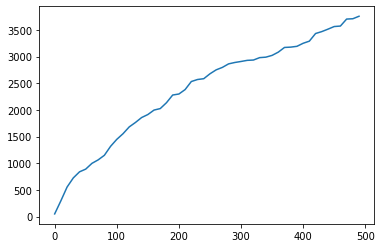

Final Q size (table): 3755 different states saved

Pacman died! Score: -514
Pacman emerges victorious! Score: 499
Pacman emerges victorious! Score: 499
Average Score: 161.33333333333334
Scores:        -514.0, 499.0, 499.0
Win Rate:      2/3 (0.67)
Record:        Loss, Win, Win


In [55]:
#options = ["-pApproximateQAgent", "-x2000", "-n2003", "-lsmallClassic"]
options = ["-pPacmanQAgent", "-x500", "-n503", "-lsmallGrid"]#"-gDirectionalGhost"
# options = ["-pNNQAgent", "-aextractor=SimpleExtractor",
#            "-x1", "-n3", "-k1", "-gRandomGhost","-lsmallClassic"]
args = readCommand(options)  # Get game components based on options
runGames(**args)

In [ ]:
print("Q (table) size: "+str(45), end="\r")
print("Q (table) size: "+str(46), end="\r")

In [5]:
# From layout of chars to layout of numbers
# Beware: This will be painful to see
def ascii_state_to_numeric_state(ascii_state):
    str_state = str(ascii_state)
    score_pos = str(str_state).find("Score: ")
    ascii_map = str(str_state)[:score_pos-1]

    numer_map = np.ndarray(len(ascii_map)+1)
    for i, c in enumerate(ascii_map):
        if c==' ':
            numer_map[i] = 1
            continue
        if c=='%':
            numer_map[i] = 2
            continue
        if c=='.':
            numer_map[i] = 3
            continue
        if c=='\n':
            numer_map[i] = 4
            continue
        if c=='G':
            numer_map[i] = 5
            continue
        if c=='o':
            numer_map[i] = 6
            continue
        # Pacman dirs
        if c=='<':
            numer_map[i] = 7
            continue
        if c=='>':
            numer_map[i] = 8
            continue
        if c=='^':
            numer_map[i] = 9
            continue
        if c=='v':
            numer_map[i] = 10
            continue
    numer_map /= 15.0
    #last array position will contain the score
    numer_map[-1] = float(str_state[score_pos+7:])/3000
    return numer_map

In [6]:
numer_map = ascii_state_to_numeric_state(SOME_GLOBAL_STATE)
ascii_map = SOME_GLOBAL_STATE
print ("Ascii map:")
print (ascii_map)
print ("Numeric map:")
print (numer_map)
print("Score normalizado:", numer_map[-1])
print(len(numer_map))

Ascii map:
%%%%%%%
%     %
% %%% %
% %   %
% %%%G%
%.    %
%%%%%%%
Score: -520

Numeric map:
[ 0.13333333  0.13333333  0.13333333  0.13333333  0.13333333  0.13333333
  0.13333333  0.26666667  0.13333333  0.06666667  0.06666667  0.06666667
  0.06666667  0.06666667  0.13333333  0.26666667  0.13333333  0.06666667
  0.13333333  0.13333333  0.13333333  0.06666667  0.13333333  0.26666667
  0.13333333  0.06666667  0.13333333  0.06666667  0.06666667  0.06666667
  0.13333333  0.26666667  0.13333333  0.06666667  0.13333333  0.13333333
  0.13333333  0.33333333  0.13333333  0.26666667  0.13333333  0.2
  0.06666667  0.06666667  0.06666667  0.06666667  0.13333333  0.26666667
  0.13333333  0.13333333  0.13333333  0.13333333  0.13333333  0.13333333
  0.13333333 -0.17333333]
Score normalizado: -0.17333333333333334
56


In [7]:
np.concatenate((numer_map, [2]))

array([ 0.13333333,  0.13333333,  0.13333333,  0.13333333,  0.13333333,
        0.13333333,  0.13333333,  0.26666667,  0.13333333,  0.06666667,
        0.06666667,  0.06666667,  0.06666667,  0.06666667,  0.13333333,
        0.26666667,  0.13333333,  0.06666667,  0.13333333,  0.13333333,
        0.13333333,  0.06666667,  0.13333333,  0.26666667,  0.13333333,
        0.06666667,  0.13333333,  0.06666667,  0.06666667,  0.06666667,
        0.13333333,  0.26666667,  0.13333333,  0.06666667,  0.13333333,
        0.13333333,  0.13333333,  0.33333333,  0.13333333,  0.26666667,
        0.13333333,  0.2       ,  0.06666667,  0.06666667,  0.06666667,
        0.06666667,  0.13333333,  0.26666667,  0.13333333,  0.13333333,
        0.13333333,  0.13333333,  0.13333333,  0.13333333,  0.13333333,
       -0.17333333,  2.        ])

In [8]:
SOME_GLOBAL_STATE.inspect

AttributeError: 'GameState' object has no attribute 'inspect'

In [ ]:
# if __name__ == '__main__':
#     """
#     The main function called when pacman.py is run
#     from the command line:

#     > python pacman.py

#     See the usage string for more details.

#     > python pacman.py --help
#     """
#     args = readCommand(sys.argv[1:])  # Get game components based on input
#     runGames(**args)

#     # import cProfile
#     # cProfile.run("runGames( **args )")
#     pass
